### MAST30034: Applied Data Science Project 1
---
# Data Analysis: Modelling Average Trip Rates Over Time
#### Xavier Travers (1178369)

TODO: Modelling Average Trip Rates Over Time

In [1]:
# imports used throughout this notebook
from collections import defaultdict
from itertools import product
import os
import sys
from pyspark.sql import DataFrame, Column
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import geopandas

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

# for printouts
DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/13 18:56:02 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.26.235.73 instead (on interface eth0)
22/08/13 18:56:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/13 18:56:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Grouped by Pick-Up Location

In [3]:
# read in the aggregated tlc by pickup data
tlc_pu_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,timeline,pu_borough,num_*,tot_passengers,daily_avg_passengers,avg_passengers,tot_trip_distance,daily_avg_trip_distance,avg_trip_distance,tot_hours_elapsed,daily_avg_hours_elapsed,avg_hours_elapsed
2020,5,2020-05-09,post,Queens,2069,2451.0,350.14285714285717,1.1846302561623974,14031.180000000013,2004.4542857142876,6.781623972933791,642.1411111111127,91.73444444444466,0.31036303098652135
2020,5,2020-05-30,post,Staten Island,7,8.0,1.1428571428571428,1.1428571428571428,69.78,9.968571428571428,9.968571428571428,3.4838888888888886,0.49769841269841264,0.49769841269841264
2021,1,2021-01-23,post,Manhattan,279566,394796.0,56399.42857142857,1.4121745848922973,592875.1000000045,84696.4428571435,2.120698153566616,58642.183611110966,8377.45480158728,0.20976150036524815
2020,5,2020-05-16,post,Brooklyn,986,1334.0,190.57142857142858,1.3529411764705883,3984.920000000005,569.2742857142864,4.041501014198788,316.52833333333365,45.218333333333376,0.32102265043948647
2020,4,2020-04-25,post,Staten Island,15,17.0,2.4285714285714284,1.1333333333333333,155.99,22.284285714285716,10.399333333333335,51.507777777777775,7.358253968253968,3.4338518518518515


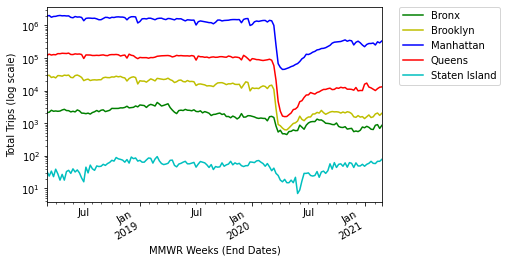

In [4]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_pu_df.toPandas(), 'num_*', 'pu_borough', 
    ylabel = 'Total Trips', logy = True)

Note that there appears to be no data past March 2021.
This is likely due to 

### Grouped by Drop-Off Location

In [5]:
# read in the aggregated tlc by dropoff data
tlc_do_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/by_do')
tlc_do_df.limit(5)

week_year,week_month,week_ending,timeline,do_borough,num_*,tot_passengers,daily_avg_passengers,avg_passengers,tot_trip_distance,daily_avg_trip_distance,avg_trip_distance,tot_hours_elapsed,daily_avg_hours_elapsed,avg_hours_elapsed
2020,5,2020-05-09,post,Queens,2598,3202.0,457.42857142857144,1.2324865280985373,14346.730000000014,2049.532857142859,5.522220939183993,777.5375000000009,111.07678571428585,0.29928310238645145
2020,5,2020-05-30,post,Staten Island,36,52.0,7.428571428571429,1.4444444444444444,469.55,67.07857142857144,13.043055555555556,69.26166666666666,9.894523809523808,1.923935185185185
2021,1,2021-01-23,post,Manhattan,272402,384965.0,54995.0,1.41322383829781,572161.730000005,81737.39000000071,2.1004314579188295,54934.86666666668,7847.838095238098,0.20166836758418324
2020,5,2020-05-16,post,Brooklyn,2568,3285.0,469.2857142857143,1.2792056074766356,16621.290000000037,2374.4700000000053,6.472464953271043,1246.650833333335,178.09297619047643,0.4854559319833859
2020,4,2020-04-25,post,Staten Island,22,25.0,3.5714285714285716,1.1363636363636365,276.29999999999995,39.47142857142857,12.559090909090907,32.635555555555555,4.662222222222222,1.4834343434343433


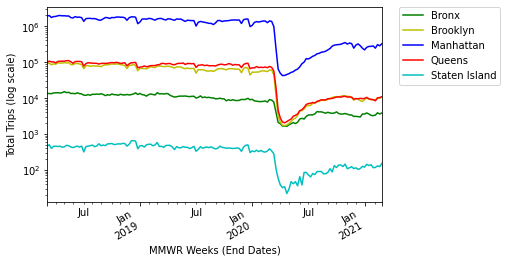

In [6]:
# generate a time series graph of daily avg trips vs week index.
ph.time_series(tlc_do_df.toPandas(), 'num_*', 'do_borough', 
    ylabel = 'Total Trips', logy = True)